In [14]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from synthid_text.detector_frequentist import frequentist_score, weighted_frequentist_score
from scipy.stats import norm
import matplotlib.ticker as ticker

In [15]:
MODEL_NAME = "google/gemma-2b-it"
TEMPERATURE = 0.5
ROC_TOKEN_LIMIT = 200 #for second ROC curve where we only consider the first e.g. 200 tokens
USE_WEIGHTED = True
IS_WATERMARKED = True
ROC_SEGMENTS = 5

In [16]:
F_MODEL_NAME = MODEL_NAME.replace("/", "_")
frequentist_score = frequentist_score if not USE_WEIGHTED else weighted_frequentist_score
WM_STR = "wm" if IS_WATERMARKED else "uwm"
WM_SUFFIX = " (unwatermarked)" if not IS_WATERMARKED else ""
WEIGHTED_SUFFIX = " (weighted)" if USE_WEIGHTED else " (unweighted)"

In [17]:
padded_eli5_g_values = torch.load(f"../frequentist_experiment_data/eli5_g_values_{F_MODEL_NAME}_t={TEMPERATURE}_{WM_STR}.pt", map_location=torch.device('cpu'))
padded_eli5_combined_mask = torch.load(f"../frequentist_experiment_data/eli5_combined_mask_{F_MODEL_NAME}_t={TEMPERATURE}_{WM_STR}.pt", map_location=torch.device('cpu'))
eli5_perplexities = torch.load(f"../frequentist_experiment_data/eli5_perplexities_{F_MODEL_NAME}_t={TEMPERATURE}_{WM_STR}.pt", map_location=torch.device('cpu'))

/var/folders/59/7skhmmps2b17ysy_h9b099zh0000gn/T/ipykernel_84365/4252944242.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  padded_eli5_g_values = torch.load(f"../freque

In [18]:
# Mean Response Length
torch.mean(torch.sum(padded_eli5_combined_mask, dim=1).double()).item()

260.31

In [19]:
# Perplexity
torch.exp(torch.tensor(np.sum(eli5_perplexities)) / len(padded_eli5_g_values)).item()

1.3071831464767456

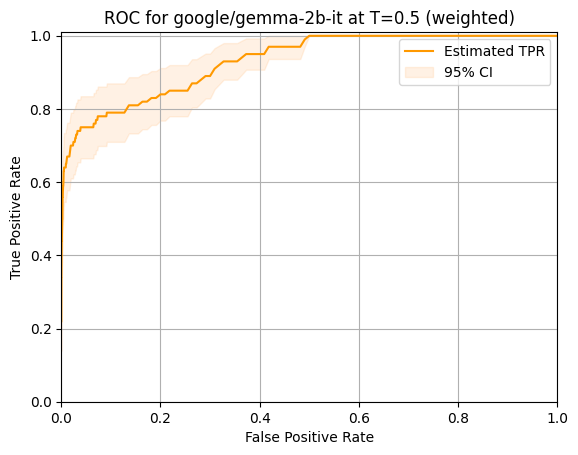

In [20]:
# ROC Curve
def ROC(freq_scores, title_suffix="", log_scale=False):
    # Given parameters
    segment_bounds = [1 / 10**(ROC_SEGMENTS -i) for i in range(ROC_SEGMENTS)] + [1]
    segments = [np.linspace(segment_bounds[i], segment_bounds[i + 1], 100) for i in range(ROC_SEGMENTS)]
    fprs = np.stack(segments).flatten()


    # Compute TPR as proportion of samples that meet criterion at each FPR threshold
    tprs = np.array([
        np.sum(-freq_scores <= fpr) / len(freq_scores)
        for fpr in fprs
    ])

    # Sample size
    n = len(freq_scores)
    z = norm.ppf(0.975)  # ~1.96 for 95% CI

    # Compute standard error for each TPR
    se = np.sqrt((tprs * (1 - tprs)) / n)

    # Compute 95% confidence intervals
    tprs_lower = tprs - z * se
    tprs_upper = tprs + z * se

    # Bound the intervals between 0 and 1
    tprs_lower = np.clip(tprs_lower, 0, 1)
    tprs_upper = np.clip(tprs_upper, 0, 1)

    # Plot
    if log_scale:
        fprs = np.log(fprs)
    plt.plot(fprs, tprs, label='Estimated TPR', color='#ff9900')
    plt.fill_between(fprs, tprs_lower, tprs_upper, color='#ffbb78', alpha=0.2, label='95% CI')
    plt.title(f"ROC for {MODEL_NAME} at T={TEMPERATURE}{title_suffix}" + WM_SUFFIX + WEIGHTED_SUFFIX)
    plt.xlabel("False Positive Rate" + (" (log scale)" if log_scale else ""))
    plt.ylabel("True Positive Rate")
    plt.ylim(0, 1.01)
    plt.xlim(0, 1.0)

    if log_scale:
        plt.xticks(np.log(segment_bounds), [f"{b:.0e}" for b in segment_bounds])


    plt.legend()
    plt.grid()

    plt.show()
    
eli5_freq_scores = frequentist_score(
    padded_eli5_g_values.cpu().numpy(),
    padded_eli5_combined_mask.cpu().numpy()
)
ROC(eli5_freq_scores, log_scale=False)

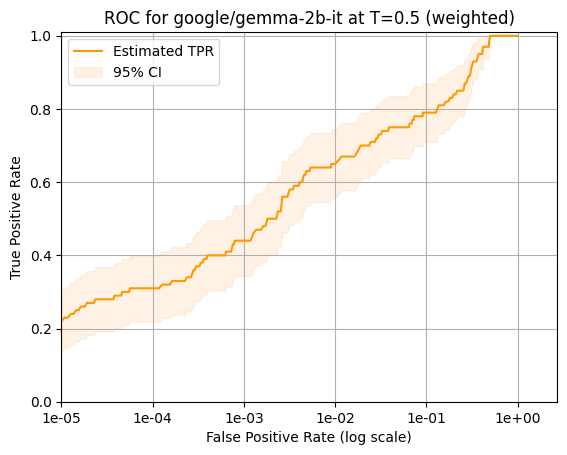

In [21]:
# Log scale ROC curve
ROC(eli5_freq_scores, log_scale=True)

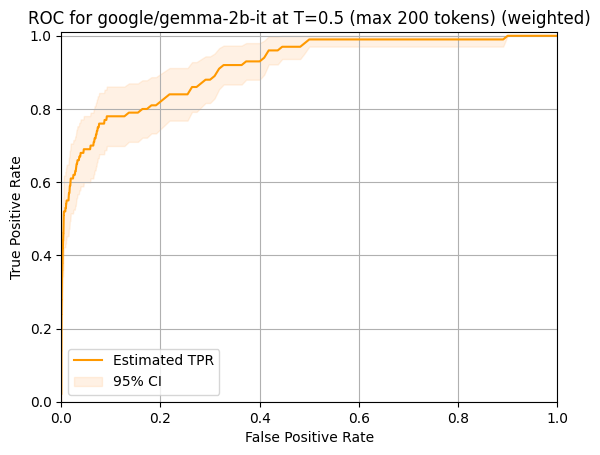

In [22]:
# ROC Curve for first ROC_TOKEN_LIMIT tokens
# To avoid having models that output more text getting better detectability

eli5_freq_scores_limited = frequentist_score(
    padded_eli5_g_values.cpu().numpy()[:,:ROC_TOKEN_LIMIT,:], padded_eli5_combined_mask.cpu().numpy()[:,:ROC_TOKEN_LIMIT]
)

ROC(eli5_freq_scores_limited, f" (max {ROC_TOKEN_LIMIT} tokens)", log_scale=False)


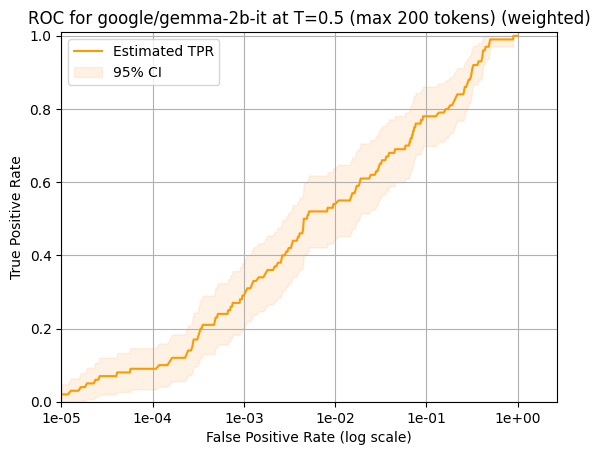

In [23]:
# log scale with token limit
ROC(eli5_freq_scores_limited, f" (max {ROC_TOKEN_LIMIT} tokens)", log_scale=True)